In [ ]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

In [ ]:
api = wandb.Api()

In [ ]:
run = api.run("pjajal/inference-diffusion-noise-optim/fv5iu18q")

In [ ]:
scan_history = run.scan_history()

In [ ]:
def flatten_log(log):
    out = {}
    for k, v in log.items():
        if isinstance(v, dict):
            for k2, v2 in v.items():
                out[f"{k}.{k2}"] = v2
        elif isinstance(v, list):
            if len(v) == 1:
                out[k] = v[0]
        else:
            out[k] = v
    return out

In [ ]:
logs = []
for log in scan_history:
    logs.append(flatten_log(log))

In [ ]:
all_data = pd.DataFrame(logs)

In [ ]:
all_data

In [ ]:
unq_prompts = {i: prompt for i, prompt in enumerate(all_data['prompt'].unique())}
reverse_unq_prompts = {v: k for k, v in unq_prompts.items()}
with open("./eval_results/fv5iu18q/prompts.json", "w") as f:
    json.dump(unq_prompts, f)

In [ ]:
all_data.loc[0]['best_img.path']

In [ ]:
# For each prompt, extract the row corresponding to the 0-th step and the step with the maximum pop_best_eval
best_worst = []
for prompt, df_group in all_data.groupby("prompt"):
    step_0_row = df_group[df_group["step"] == 0]
    max_pop_best_eval_row = df_group.loc[df_group["pop_best_eval"].idxmax()]
    idx_prompt = reverse_unq_prompts[prompt]
    
    save_loc = f"eval_results/fv5iu18q/{idx_prompt}/"
    os.makedirs(save_loc, exist_ok=True)
    baseline_status = run.file(step_0_row['best_img.path'].item()).download()
    max_status = run.file(max_pop_best_eval_row['best_img.path']).download()
    
    os.renames(baseline_status.name, os.path.join(save_loc, "baseline.png"))
    os.renames(max_status.name, os.path.join(save_loc, "max.png"))
    best_worst.append({"prompt": prompt, "baseline": step_0_row['pop_best_eval'].item(), "best": max_pop_best_eval_row['pop_best_eval'].item()})
    print(
        f"Prompt: {prompt}, Step 0: {step_0_row['pop_best_eval'].item()}, Max Pop Best Eval: {max_pop_best_eval_row['pop_best_eval'].item()}"
    )

best_worst_results = pd.DataFrame(best_worst)
best_worst_results.to_csv("eval_results/fv5iu18q/best_worst_results.csv", index=False)

In [50]:
from PIL import Image
import hpsv2
import ImageReward
import os
import json
from diffusers.utils import pt_to_pil, numpy_to_pil
import numpy as np

In [ ]:
eval_results_loc = "eval_results/fv5iu18q/"
prompts_file = os.path.join(eval_results_loc, "prompts.json")
best_worst_file = os.path.join(eval_results_loc, "best_worst_results.csv")

with open(prompts_file, "r") as f:
    prompt_dict = json.load(f)

In [ ]:
for idx, prompt in prompt_dict.items():
    img_save_loc = os.path.join(eval_results_loc, idx)
    
    print(img_save_loc)

In [ ]:
img_save_loc = "eval_results/fv5iu18q/1"
baseline_path = os.path.join(img_save_loc, "baseline.png")
max_path = os.path.join(img_save_loc, "max.png")
img = Image.open(baseline_path)
prompt = prompt_dict["1"]
print(prompt)

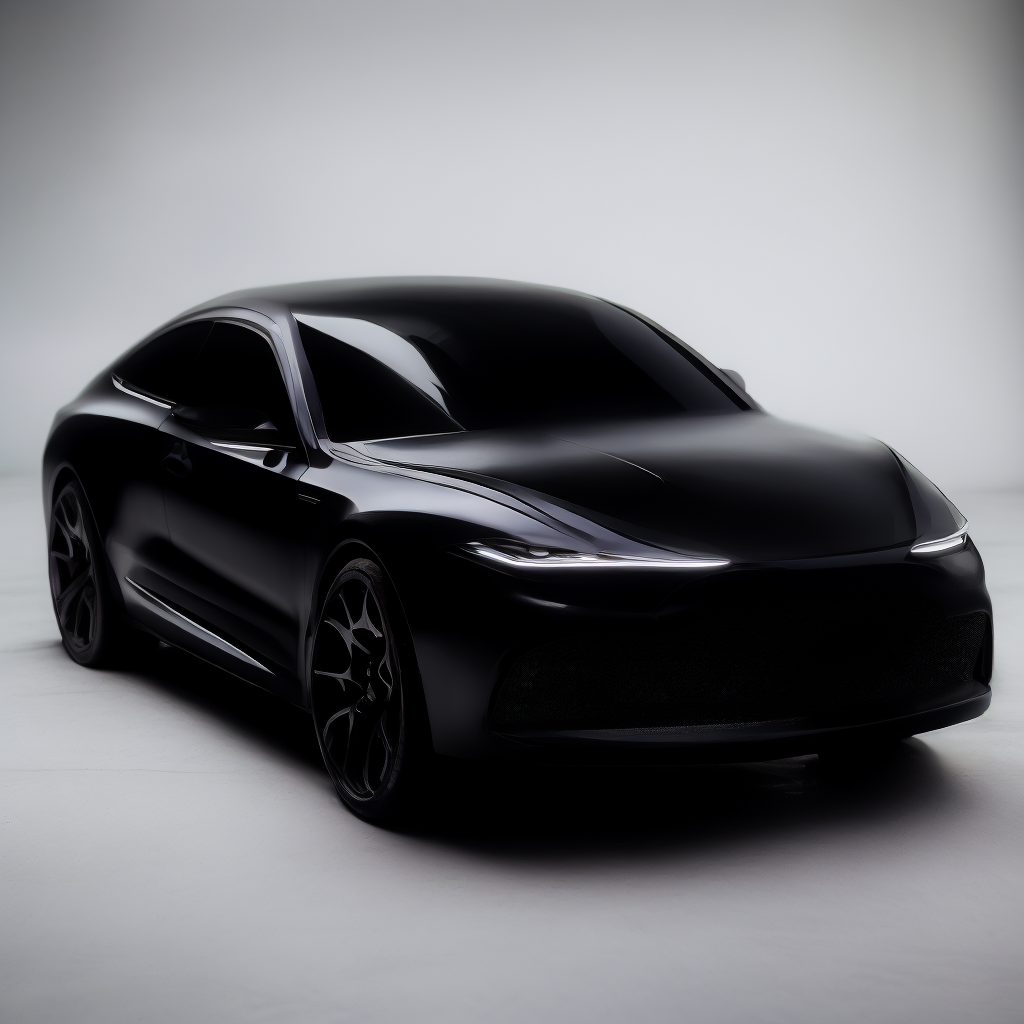

In [59]:
numpy_to_pil(np.array(img) / 255)[0]

In [63]:
img_reward = ImageReward.load("ImageReward-v1.0")
img_reward = img_reward.eval()

img_reward.score(prompt=prompt, image=max_path), img_reward.score(prompt=prompt, image=numpy_to_pil(np.array(img) / 255)[0])

load checkpoint from /Users/jajal/.cache/ImageReward/ImageReward.pt
checkpoint loaded


(0.7362620234489441, 0.4993453025817871)

In [ ]:
hpsv2.score(imgs_path=[baseline_path, max_path], prompt=prompt)

In [ ]:
run.file("media/images/best_img_0_94bb6bfd37309fa55b50.png").download()